# Сравнение PSO и Grid Search для настройки гиперпараметров на MNIST

In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import ParameterGrid
from pyswarm import pso
import numpy as np
import matplotlib.pyplot as plt
import time

### Загрузка и подготовка данных

In [2]:
# Загрузка данных MNIST
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Нормализация данных
x_train = x_train.reshape(-1, 28*28).astype('float32') / 255.0
x_test = x_test.reshape(-1, 28*28).astype('float32') / 255.0

# Преобразование меток в one-hot encoding
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

### Определение вспомогательных функций

In [6]:
# Функция для создания и обучения модели
def create_model(num_neurons, learning_rate):
    model = Sequential([
        Flatten(input_shape=(28*28,)),
        Dense(num_neurons, activation='relu'),
        Dense(10, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Функция для оценки модели
def evaluate_model(params):
    num_neurons, learning_rate = params
    model = create_model(int(num_neurons), learning_rate)
    model.fit(x_train, y_train, epochs=5, batch_size=32, verbose=0)
    loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
    return 1 - accuracy  # Минимизируем ошибку

# Функция для Grid Search
def grid_search(params_grid):
    best_params = None
    best_score = float('inf')
    for params in ParameterGrid(params_grid):
        score = evaluate_model([params['num_neurons'], params['learning_rate']])
        if score < best_score:
            best_score = score
            best_params = params
    return best_params, best_score

# Функция для PSO
def pso_objective(params):
    num_neurons, learning_rate = params
    return evaluate_model([num_neurons, learning_rate])


### Запуск Grid Search

In [7]:
params_grid = {
    'num_neurons': [32, 64, 128],
    'learning_rate': [0.001, 0.01, 0.1]
}

start_time = time.time()
best_params_grid, best_score_grid = grid_search(params_grid)
grid_search_time = time.time() - start_time
print(f"Grid Search took {grid_search_time:.3f} seconds.")
best_params_grid, best_score_grid

Grid Search took 134.488 seconds.


({'learning_rate': 0.001, 'num_neurons': 128}, 0.0252000093460083)

### Запуск PSO

In [8]:
lb = [32, 0.001]  # Нижние границы
ub = [128, 0.1]   # Верхние границы

start_time = time.time()
best_params_pso, best_score_pso = pso(pso_objective, lb, ub, swarmsize=10, maxiter=10)
pso_time = time.time() - start_time
print(f"PSO took {pso_time:.3f} seconds.")
best_params_pso, best_score_pso

Stopping search: maximum iterations reached --> 10
PSO took 1800.751 seconds.


(array([1.02567795e+02, 1.00000000e-03]), 0.021000027656555176)

### Визуализация и сравнительный анализ

In [9]:
# Сравнение результатов
results = [
    {'method': 'Grid Search', 'params': best_params_grid, 'score': best_score_grid, 'time': grid_search_time},
    {'method': 'PSO', 'params': best_params_pso, 'score': best_score_pso, 'time': pso_time}
]
results

[{'method': 'Grid Search',
  'params': {'learning_rate': 0.001, 'num_neurons': 128},
  'score': 0.0252000093460083,
  'time': 134.488196849823},
 {'method': 'PSO',
  'params': array([1.02567795e+02, 1.00000000e-03]),
  'score': 0.021000027656555176,
  'time': 1800.751333475113}]

### Визуализация результатов

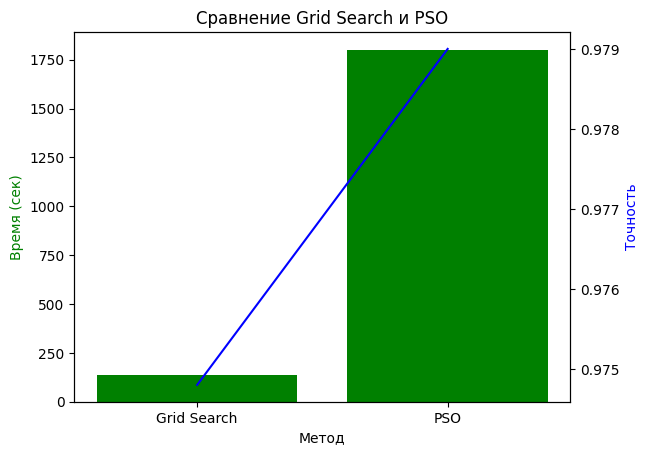

In [10]:
# Построение графика сравнения времени и точности
methods = [result['method'] for result in results]
times = [result['time'] for result in results]
scores = [1 - result['score'] for result in results]  # Переводим обратно к точности

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.bar(methods, times, color='g')
ax2.plot(methods, scores, color='b')

ax1.set_xlabel('Метод')
ax1.set_ylabel('Время (сек)', color='g')
ax2.set_ylabel('Точность', color='b')

plt.title('Сравнение Grid Search и PSO')
plt.show()